In [11]:
import pymania as mn
import pylab as plt

In [36]:
subs = [126426, 137431, 144125, 146735, 152427, 153227, 177140, 180533, 186545, 188145]
D = {1:('L1','L155',5,25,[153227,144125,188145,152427,137431]),
2:('L2','L158',5,25,[153227,188145,186545,152427,137431]),
3:('L3','L46',5,25,[153227,126426,186545,152427,137431]),
4:('L4','L176',5,25,[153227,126426,177140,146735,137431]),
5:('L5','L177',5,25,[153227,144125,126426,177140,146735]),
6:('L180','L122',5,25,[153227,186545,180533,177140,152427]),
7:('L179','L70',5,25,[188145,180533,177140,152427,146735]),
8:('L178','L168',5,25,[153227,144125,126426,177140,137431]),
9:('L177','L13',5,25,[153227,126426,188145,177140,137431]),
10:('L176','L23',5,25,[153227,186545,152427,146735,137431])}

KeyboardInterrupt: 

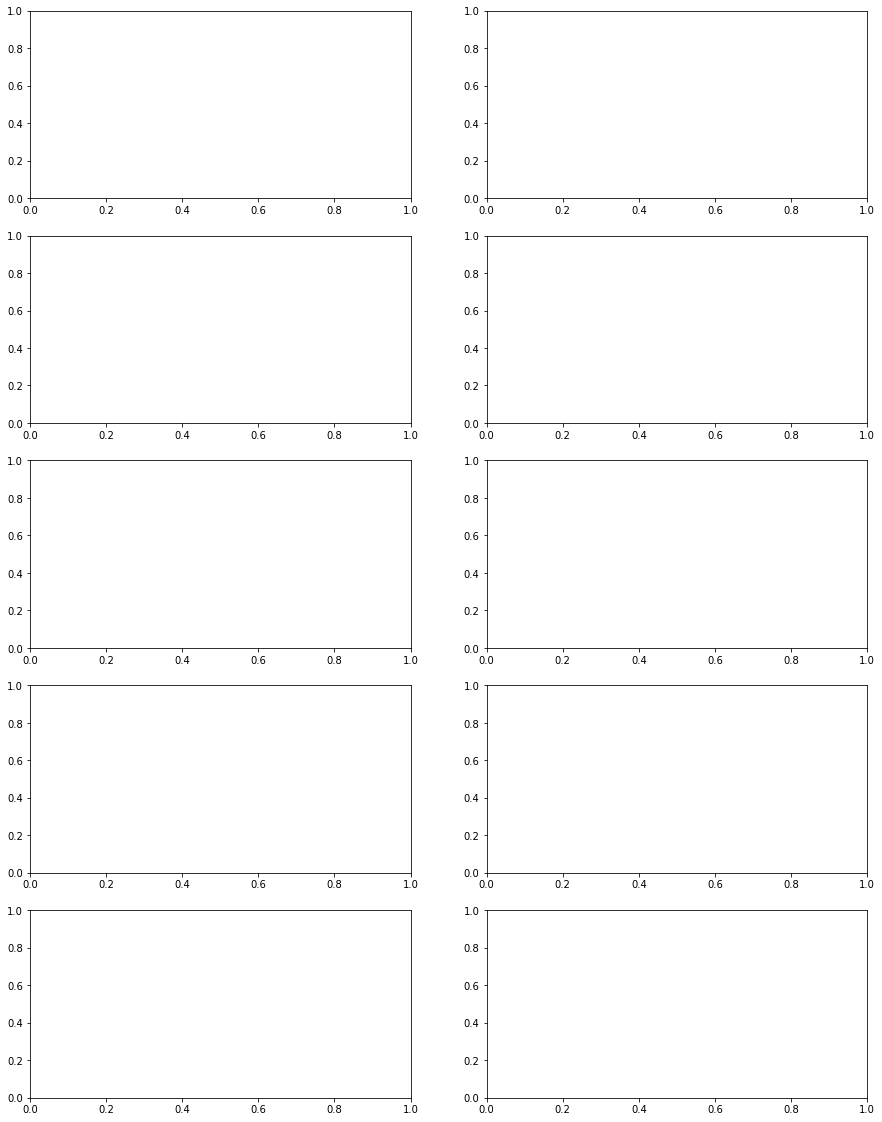

In [44]:
c = 10 # connection num
fig, ax  = plt.subplots(5,2,figsize=(15,20))
for i,sub in enumerate(subs):
    a = mn.ST(subs[i],D[c][0],D[c][1])
    if sub in D[c][-1]:
        ax[(i)//2,i%2].set_facecolor('#DDFACB')
    else:
        ax[(i)//2,i%2].set_facecolor('#FCC1C0')
    try:
        a.process()
    except:
        pass
    a.plot(ax[(i)//2,i%2])
    if a.isNull():
        ax[(i)//2,i%2].set_facecolor('#000000')
        ax[(i)//2,i%2].text(0.05,.9,f'SUB:{subs[i]}',color="white")
    else:
        ax[(i)//2,i%2].text(0,-1,f'SUB:{subs[i]}',color="black")
plt.tight_layout()